## Importuri necesare

In [1]:
import glob
import cv2 as cv
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from copy import deepcopy
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import os
import matplotlib.pyplot as plt

## Incarcarea imaginilor

In [2]:
def load_images_and_labels(path, image_size=(300, 300)):

    folders = glob.glob(os.path.join(path, '*'))

    images = []
    labels = []

    for folder in folders:
        clas = os.path.basename(folder) 
        print(f"Procesam clasa: {clas}")

        files = glob.glob(os.path.join(folder, '*.jpg'))
        for file in files:
            image = cv.imread(file)
            image = cv.resize(image, image_size, interpolation=cv.INTER_LINEAR)
            img_array = np.asarray(image)

            images.append(img_array)
            labels.append(clas)

    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [3]:
train_images,train_labels=load_images_and_labels('data/train1')
test_images,test_labels=load_images_and_labels('data/test1')

Procesam clasa: soccer_ball
Procesam clasa: yin_yang
Procesam clasa: soccer_ball
Procesam clasa: yin_yang


In [4]:
print(train_images.shape)
print(test_images.shape)

(94, 300, 300, 3)
(30, 300, 300, 3)


## Diferite tipuri de descriptori clasici

In [5]:
def get_flatten_images(images):
    images_flatten=[]
    for img in images:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img=img.flatten()
        images_flatten.append(img)
    images_flatten = np.array(images_flatten)
    return images_flatten

In [6]:
def get_gray_histogram(images):
    gray_histograms = []
    for img in images:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        hist = cv.calcHist([img], [0], None, [256], [0, 256])
        gray_histograms.append(hist.flatten())
    gray_histograms = np.array(gray_histograms)
    return gray_histograms

In [7]:
def get_rgb_histogram(images):
    color_histograms = []
    for img in images:
        hist = cv.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        color_histograms.append(hist.flatten())
    color_histograms = np.array(color_histograms)
    return color_histograms

In [8]:
def get_hog_descriptors(images):
    descriptors = []
    for img in images:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        features = hog(img, pixels_per_cell=(6, 6),orientations=8, cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
        descriptors.append(features)
    descriptors = np.array(descriptors)
    return descriptors

## Descriptori din retele neuronale

In [9]:
def get_neural_network_descriptors(images_np, model_name='resnet18'):
    if model_name == 'resnet18':
        from torchvision.models import resnet18
        model = resnet18(pretrained=True)
        layer = model._modules.get('avgpool')  
        embedding_dim = 512
    elif model_name == 'vgg16':
        from torchvision.models import vgg16
        model = vgg16(pretrained=True)
       
        layer = model.features[-1]  
        embedding_dim = 512
    elif model_name == 'alexnet':
        from torchvision.models import alexnet
        model = alexnet(pretrained=True)
        
        layer = model.features[-1]  
        embedding_dim = 256
    else:
        raise ValueError(f"Modelul {model_name} nu este suportat.")

    model.eval()

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    descriptors = []
    for i, img_np in enumerate(images_np):
        img_tensor = preprocess(img_np).unsqueeze(0)  
        img_tensor = Variable(img_tensor)

        
        my_embedding = torch.zeros(embedding_dim)

        def copy_data(m, i, o):
            
            my_embedding.copy_(o.data.mean(dim=[2, 3]).view(-1))  

        h = layer.register_forward_hook(copy_data)
        model(img_tensor)
        h.remove()

        descriptors.append(my_embedding.numpy())

    descriptors = np.array(descriptors)
    return descriptors


### Calcularea descriptorilor pentru imaginile de antrenare si testare

In [10]:
train_images_flatten=get_flatten_images(train_images)
test_images_flatten=get_flatten_images(test_images)

In [11]:
train_images_gray_hist=get_gray_histogram(train_images)
test_images_gray_hist=get_gray_histogram(test_images)

In [12]:
train_images_color_hist=get_rgb_histogram(train_images)
test_images_color_hist=get_rgb_histogram(test_images)

In [13]:
train_images_hog=get_hog_descriptors(train_images)
test_images_hog=get_hog_descriptors(test_images)

In [14]:
train_descriptors_resnet = get_neural_network_descriptors(train_images, model_name='resnet18')
train_descriptors_vgg = get_neural_network_descriptors(train_images, model_name='vgg16')
train_descriptors_alexnet = get_neural_network_descriptors(train_images, model_name='alexnet')


test_descriptors_resnet = get_neural_network_descriptors(test_images, model_name='resnet18')
test_descriptors_vgg = get_neural_network_descriptors(test_images, model_name='vgg16')
test_descriptors_alexnet = get_neural_network_descriptors(test_images, model_name='alexnet')


/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.

### Antrenarea unui SVM liniar cu diferiti descriptori

In [15]:
def train_model(train_descriptors, train_labels, Cs=None):
    
    if Cs is None:
        Cs = [10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10 ** 0]

    best_accuracy = 0
    best_c = 0
    best_model = None

    for c in Cs:
        #print(f'Antrenăm un clasificator pentru C={c}')
        model = LinearSVC(C=c)
        model.fit(train_descriptors, train_labels)
        acc = model.score(train_descriptors, train_labels)
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_c = c
            best_model = deepcopy(model)

    #print(f'Performanța clasificatorului optim pentru C={best_c}: {best_accuracy}')
    
    return best_model


In [16]:
model=train_model(train_descriptors_alexnet,train_labels)

Vectori de intensitate Accuracy: 0.7667


/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

Histograme grayscale Accuracy: 0.6000
Histograme de culori Accuracy: 0.7000


/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandradiaconu/opt/anaconda3/envs/CV/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


HOG Accuracy: 0.8333
VGG16 Accuracy: 0.8333
AlexNet Accuracy: 1.0000
ResNet18 Accuracy: 0.9000


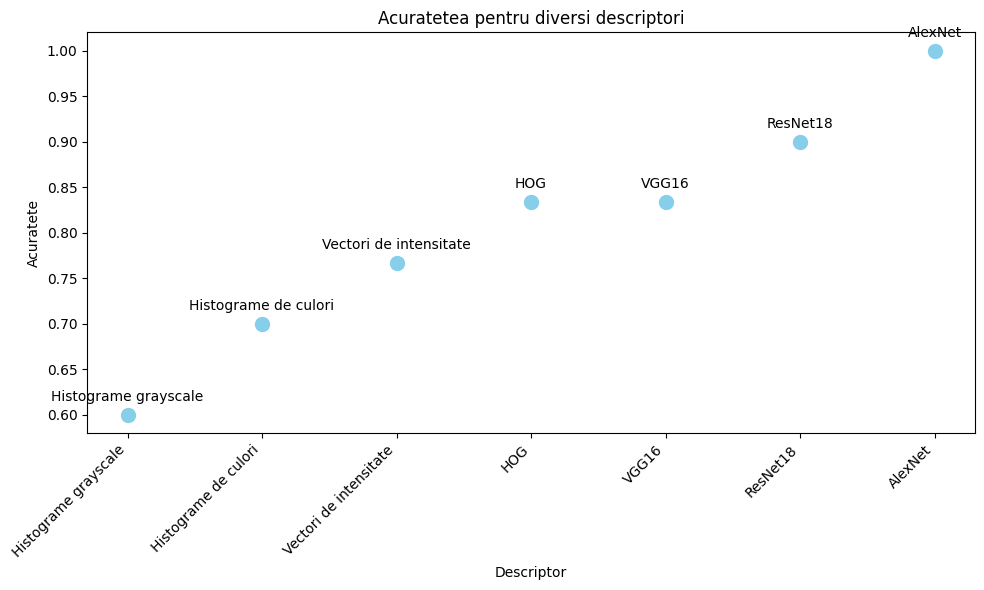

In [17]:
descriptor_names = [
    'Vectori de intensitate', 
    'Histograme grayscale', 
    'Histograme de culori', 
    'HOG', 
    'VGG16', 
    'AlexNet', 
    'ResNet18'
]

accuracies = []

for train_data, test_data, name in zip(
    [train_images_flatten, train_images_gray_hist, train_images_color_hist, 
     train_images_hog, train_descriptors_vgg, train_descriptors_alexnet, train_descriptors_resnet],
    [test_images_flatten, test_images_gray_hist, test_images_color_hist, 
     test_images_hog, test_descriptors_vgg, test_descriptors_alexnet, test_descriptors_resnet],
    descriptor_names):
    model = train_model(train_data, train_labels)
    predicted_labels = model.predict(test_data)
    accuracy = accuracy_score(test_labels, predicted_labels)
    accuracies.append(accuracy)
    
    print(f'{name} Accuracy: {accuracy:.4f}')

sorted_indices = np.argsort(accuracies)
sorted_accuracies = np.array(accuracies)[sorted_indices]
sorted_descriptor_names = np.array(descriptor_names)[sorted_indices]


x_positions = np.arange(len(descriptor_names)) 

plt.figure(figsize=(10, 6))
plt.scatter(x_positions, sorted_accuracies, color='skyblue', s=100)  


for i, txt in enumerate(sorted_descriptor_names):
    plt.annotate(txt, (x_positions[i], sorted_accuracies[i]), textcoords="offset points", xytext=(0, 10), ha='center')


plt.xticks(x_positions, sorted_descriptor_names, rotation=45, ha='right')

plt.xlabel('Descriptor')
plt.ylabel('Acuratete')
plt.title('Acuratetea pentru diversi descriptori')
plt.tight_layout()


plt.show()
